In [1]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 117.1 MB/s eta 0:00:0000:010:01
  Using cached matplotlib-3.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (586.0 MB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached contourpy-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (299 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.39.4-py3-none-any.whl (1.0 MB)
  Using cached kiwisolver-1.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.4 MB)
  Using cached Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl (3.4 MB)
  Us

In [2]:

import os
import glob
import numpy as np
import scipy.io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
adam = tf.keras.optimizers.Adam(learning_rate=0.0005)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Reshape
temperature = 0.03
learning_rate=0.001

def dataloader(path, featType):
    """
    Load data from a MATLAB file.

    Args:
        path (str): Path to the MATLAB file.
        featType (int): Type of features to load.

    Returns:
        Tuple: Tuple containing input features, labels, weights, and additional information.
    """
    data = scipy.io.loadmat(path)
    print(data.keys())

    AF = data['AF']
    x1 = AF[:-2]
    y = AF[-2]
    w = AF[-1]

    if featType == 1:
        x = x1
    else:
        x2 = data['CF']
        x = np.concatenate((x1, x2), axis=0)
    return x.T, y.T, w.T, data['CF_info']

def calculate_accuracy(arr1, arr2):
    """
    Calculate the accuracy between two arrays.

    Args:
        arr1 (array): First array.
        arr2 (array): Second array.

    Returns:
        float: Accuracy between the two arrays.
    """
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

def normalization(feats):

    """
    Normalize the input features using standard scaling.

    Args:
        feats (array): Input features.

    Returns:
        array: Normalized features.
    """
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new

def make_partitions(arr_words, arr_labels):

    """
    Create partitions based on word boundaries and labels.

    Args:
        arr_words (array): Array of words.
        arr_labels (array): Array of labels.

    Returns:
        array: Partitions based on word boundaries and labels.
    """
    v = []
    temp = []

    for i in range(len(arr_words) - 1):
        word = arr_words[i]
        next_word = arr_words[i + 1]
        temp.append(arr_labels[i])

        if word != next_word or i == len(arr_words) - 2:
            if i == len(arr_words) - 2:
                temp.append(arr_labels[i + 1])

            numpy_temp = np.array(temp)
            temp_max = np.amax(numpy_temp)
            numpy_temp = np.divide(numpy_temp, temp_max)
            v = np.concatenate((v, numpy_temp), axis=None)
            temp.clear()

    v1 = [1 if i == 1 else 0 for i in v]
    return v1
    
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
featType = 1; #Acoustic or Acoustic+context
if featType == 1:
  original_dim = 19
else:
  original_dim = 38
# print('Classification with::::::',os.path.basename(filee))
train_path = filee; test_path = filee.replace('train','test')
# print('test file:::::::',os.path.basename(test_path))
xtrain, ytrain, wtrain, info_train = dataloader(train_path, featType); 
xtrain1, ytrain1, wtrain1, info_train1 = dataloader(train_path, featType=2);
xtest, ytest, wtest ,info_test = dataloader(test_path, featType)
xtest1, ytest1, wtest1, info_test1 = dataloader(test_path, featType=2);
xtest_a = normalization(xtest)
xtest_ac = normalization(xtest1)
xtrain = normalization(xtrain)
xtrain1 = normalization(xtrain1)

woPP=[]; wPP=[]
input_shape1 = (19,1)
input_shape2 = (38,1)
temperature = 0.03
learning_rate=0.001

2023-05-29 12:07:41.630552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 12:07:41.663451: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 12:07:41.664343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 12:07:42.393771: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in M

dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])
dict_keys(['__header__', '__version__', '__globals__', 'AF', 'AF_info', 'CF', 'CF_info'])


In [6]:
print(xtrain.shape)

(5891, 19)


In [7]:
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.544833,-0.590662,-0.626010,-0.376067,-0.258656,-1.120111,-0.749749,1.051655,-0.732218,-0.854628,-0.905126,-0.805763,-0.704522,-0.620774,0.381802,-0.185397,-1.068775,-1.396762,-0.518343
1,-0.579265,0.975810,-0.341766,2.578917,2.855292,-1.296984,-1.761824,3.225731,1.456541,-0.004992,0.274017,1.978434,1.959798,-1.652176,1.134729,0.927882,0.474437,2.012922,1.173469
2,-0.865570,-1.097166,-0.961368,-1.044295,-0.961090,1.656990,-0.224349,-0.833010,-1.289587,-0.850935,-0.889988,-0.777590,-0.686590,0.664292,0.678272,-0.458778,-1.030906,-0.995623,-0.685965
3,-0.934996,-0.535512,-0.775032,-0.106340,0.115556,-0.935847,-1.726249,2.710883,-0.209264,-0.050742,-0.052814,-0.300300,-0.305078,2.819822,0.748837,-0.700969,0.414042,0.452936,-0.601504
4,-0.150541,-0.362105,-0.204646,-0.365585,-0.531458,0.262050,0.771264,-0.889548,0.039614,-0.838729,-0.878318,-0.771444,-0.684241,0.784386,0.461484,-0.627172,-1.010470,-0.995623,-0.348122


In [8]:
xtrain.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

In [10]:
xtrain.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03,5.891000e+03
mean,1.387072e-17,-1.809224e-17,8.337509e-17,4.342139e-17,9.166737e-17,-9.796347e-15,-1.975070e-16,1.203737e-15,6.913650e-15,-1.598148e-17,1.387072e-17,-1.809224e-17,-4.100909e-17,-1.245349e-14,5.077890e-16,9.287352e-16,-4.245647e-16,2.263943e-15,-2.811535e-15
std,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00,1.000085e+00
min,-1.237865e+00,-1.468728e+00,-1.307863e+00,-1.362955e+00,-1.264657e+00,-2.154496e+00,-3.908154e+00,-1.315355e+00,-1.986858e+00,-8.846183e-01,-9.321597e-01,-8.413361e-01,-7.410516e-01,-3.149216e+00,-3.930513e+00,-1.271363e+00,-1.109987e+00,-2.003702e+00,-2.121796e+00
25%,-7.402339e-01,-7.719739e-01,-7.238626e-01,-7.961467e-01,-7.920369e-01,-7.537750e-01,-7.217597e-01,-6.665994e-01,-7.830024e-01,-7.060617e-01,-7.231866e-01,-6.382542e-01,-5.781844e-01,-6.026681e-01,-6.181828e-01,-5.749248e-01,-7.713917e-01,-8.411101e-01,-8.108199e-01
50%,-2.665466e-01,-2.041876e-01,-2.469851e-01,-2.346174e-01,-2.691566e-01,-1.929780e-01,-1.069242e-02,-2.721567e-01,-5.128024e-02,-3.743291e-01,-3.519459e-01,-3.318803e-01,-3.345464e-01,2.041359e-02,2.312994e-02,-3.047826e-01,-2.929592e-01,-4.371285e-02,-2.625884e-02
75%,4.497513e-01,5.666725e-01,4.524214e-01,5.736078e-01,5.541953e-01,5.975734e-01,6.864244e-01,4.338873e-01,7.000145e-01,3.569020e-01,3.797487e-01,2.498020e-01,1.707393e-01,5.687293e-01,5.584884e-01,1.463378e-01,5.084535e-01,7.698082e-01,7.016028e-01
max,5.697328e+00,5.334137e+00,6.447940e+00,4.077036e+00,4.425107e+00,3.256408e+00,4.893879e+00,1.117633e+01,2.732381e+00,6.682067e+00,6.223888e+00,9.261766e+00,1.097457e+01,4.199373e+00,4.318967e+00,1.017377e+01,8.240731e+00,2.342361e+00,2.776922e+00


In [11]:
xtrain.columns

RangeIndex(start=0, stop=19, step=1)

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0) 

kmeans.fit(xtrain)

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [21]:
#Importing required modules
 
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
 
#Load Data
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(xtrain)
 
df.shape

(5891, 2)

In [22]:
#Import required module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 2)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
print(label)

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 ... 0 0 0]


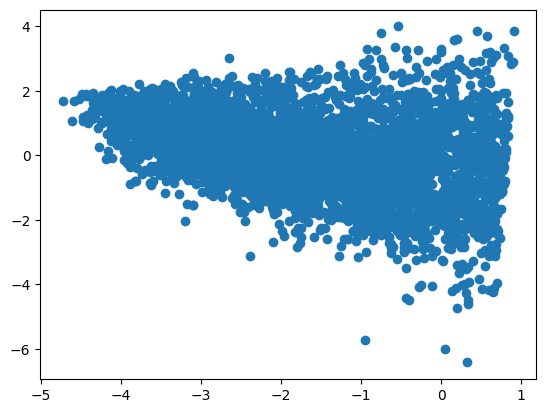

In [23]:
import matplotlib.pyplot as plt
 
#filter rows of original data
filtered_label0 = df[label == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1])
plt.show()

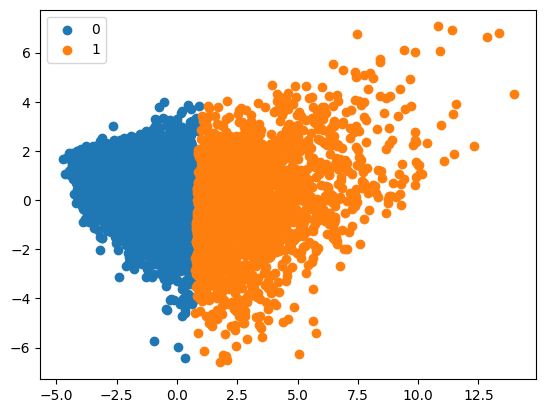

In [24]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

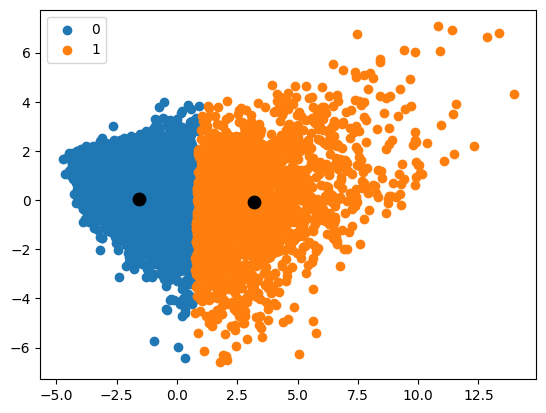

In [26]:
#Getting the Centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [35]:
xtrain.to_numpy()

array([[-0.54483264, -0.59066164, -0.62600958, ..., -1.06877463,
        -1.39676242, -0.51834311],
       [-0.57926541,  0.97580997, -0.34176562, ...,  0.47443723,
         2.0129225 ,  1.17346874],
       [-0.86556981, -1.09716585, -0.96136846, ..., -1.03090635,
        -0.99562302, -0.68596502],
       ...,
       [-0.45187871, -0.43599128, -0.44520527, ..., -1.05636479,
        -0.18443   ,  1.32726982],
       [-0.72675379, -0.53357575, -0.66981248, ...,  0.48129475,
        -0.21960929, -0.20799451],
       [-0.74869548, -0.35245038, -0.63601073, ...,  1.37714202,
         0.83576937,  0.86312014]])

In [39]:
print(xtrain.iloc[:,3])

0      -0.376067
1       2.578917
2      -1.044295
3      -0.106340
4      -0.365585
          ...   
5886   -0.511365
5887   -0.679496
5888   -0.094232
5889   -0.148337
5890    0.067402
Name: 3, Length: 5891, dtype: float64


/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


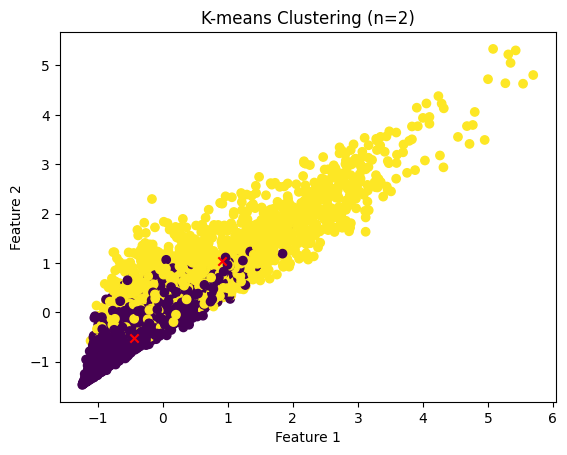

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(xtrain)

# Visualize the clusters
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering (n=2)')
plt.show()